In [96]:
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
from PIL import Image

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [97]:
random.seed(123)
seed = random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 6


# Loading and Preprocessing

In [98]:
batch_size = 32
width = 150
height = 150
data_path_train = "intel-image-classification/seg_train/seg_train"
data_path_valid = "intel-image-classification/seg_test/seg_test"

In [99]:
train_dataset = preprocessing.image_dataset_from_directory(
    directory=data_path_train,
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.


In [100]:
val_dataset = preprocessing.image_dataset_from_directory(
    directory=data_path_valid,
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 3000 files belonging to 6 classes.


# Basic CNN Model

In [110]:
def custom(classes):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    # Block 3
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    
    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())


    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))  # 1000 is the number of classes in ImageNet
    
    #Use sparse_ce since tf preprocessing encodes label like ordinal encoding
    model.compile(
        optimizer= optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])


    return model

custom_model=custom(6)
custom_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_71 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_75 (Ba  (None, 75, 75, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_72 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_72 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                     

# EfficientNet Model

In [109]:
def effnet(classes):

    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape=(150, 150, 3) , pooling= 'max')

    model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(classes , activation= 'softmax')
    ])
    
    #Use sparse_ce since tf preprocessing encodes label like ordinal encoding
    model.compile(
        optimizer= optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    

    return model

effnet_model=effnet(6)
effnet_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_74 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                                 
 dense_44 (Dense)            (None, 256)               327936    
                                                                 
 dense_45 (Dense)            (None, 256)               65792     
                                                                 
 dense_46 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 4449961 (16.98 MB)
Trainable params: 44

# Results basic Model

In [103]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=5, 
    mode ="max", 
    verbose=2, 
    restore_best_weights=True
)

In [106]:
dataset_shape = train_dataset.element_spec
print("Dataset shape:", dataset_shape)

Dataset shape: (TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [113]:
history = custom_model.fit (
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1, 
    callbacks=[stop_early]
)

Epoch 1/30
439/439 [==============================] - 18s 34ms/step - loss: 0.8822 - accuracy: 0.7030 - val_loss: 0.9595 - val_accuracy: 0.6653
Epoch 2/30
439/439 [==============================] - 12s 28ms/step - loss: 0.5663 - accuracy: 0.7965 - val_loss: 1.2082 - val_accuracy: 0.6613
Epoch 3/30
439/439 [==============================] - 12s 28ms/step - loss: 0.4508 - accuracy: 0.8362 - val_loss: 1.2503 - val_accuracy: 0.6357
Epoch 4/30
439/439 [==============================] - 12s 27ms/step - loss: 0.3863 - accuracy: 0.8574 - val_loss: 1.3658 - val_accuracy: 0.6427
Epoch 5/30
439/439 [==============================] - 12s 28ms/step - loss: 0.3240 - accuracy: 0.8830 - val_loss: 0.7123 - val_accuracy: 0.7723
Epoch 6/30
439/439 [==============================] - 12s 27ms/step - loss: 0.2565 - accuracy: 0.9067 - val_loss: 0.5855 - val_accuracy: 0.8243
Epoch 7/30
439/439 [==============================] - 12s 28ms/step - loss: 0.2065 - accuracy: 0.9247 - val_loss: 1.0402 - val_accuracy:

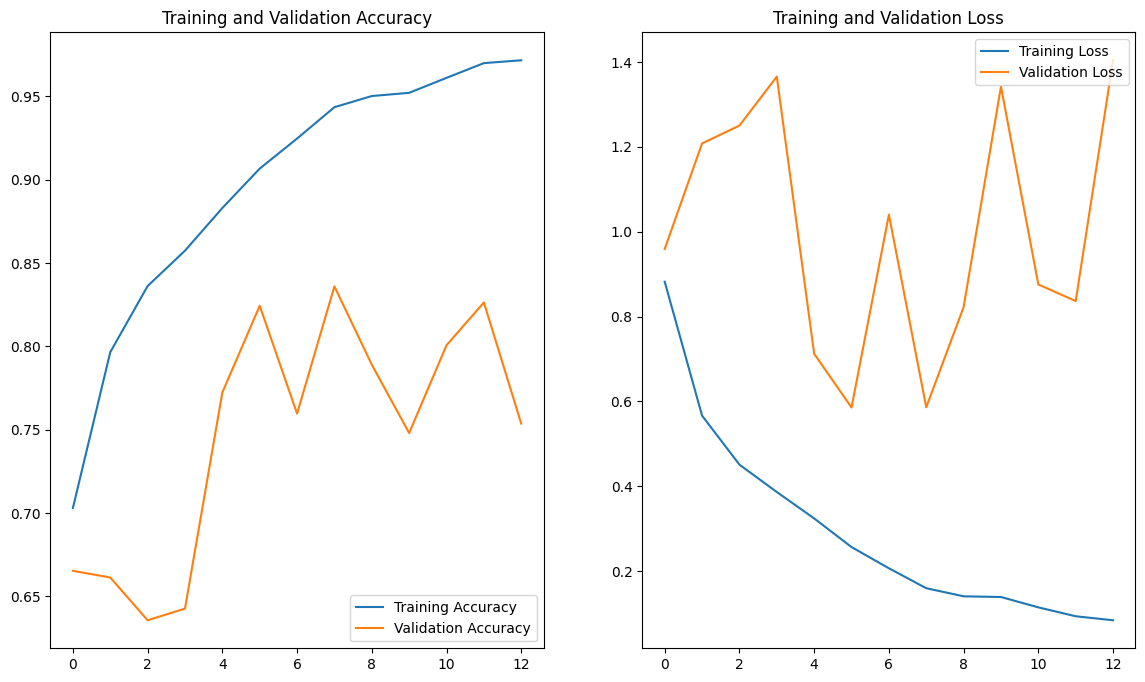

Maximum validation accuracy:  0.8360000252723694
Minimum loss: 0.586168110370636


In [114]:
# Get the accuracy results for each epoch
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Get the loss results for each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Get the epochs count
epochs_range = range(len(history.history["loss"]))

# Create the plot area
plt.figure(figsize=(14, 8))

# Setup the first colum : Accuracy plot
plt.subplot(1, 2, 1)
# Plot the training and validation accuracy for these epochs
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# Setup the legend
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Setup the second colum : Loss plot
plt.subplot(1, 2, 2)
# Plot the training and validation loss for these epochs
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
# Setup the legend
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Show the overall plot
plt.show()

position = np.argmax(history.history["val_accuracy"])
print(f"Maximum validation accuracy:  {history.history['val_accuracy'][position]}\nMinimum loss: {history.history['val_loss'][position]}")

# Results EfficientNet Model

In [111]:
history = effnet_model.fit (
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1, 
    callbacks=[stop_early]
)

Epoch 1/30


2024-02-20 13:48:33.818399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


439/439 [==============================] - 112s 151ms/step - loss: 0.4120 - accuracy: 0.8630 - val_loss: 0.2832 - val_accuracy: 0.9037
Epoch 2/30
439/439 [==============================] - 61s 139ms/step - loss: 0.2616 - accuracy: 0.9144 - val_loss: 0.2935 - val_accuracy: 0.9120
Epoch 3/30
439/439 [==============================] - 61s 140ms/step - loss: 0.2185 - accuracy: 0.9261 - val_loss: 0.2727 - val_accuracy: 0.9193
Epoch 4/30
439/439 [==============================] - 61s 139ms/step - loss: 0.1933 - accuracy: 0.9344 - val_loss: 0.3154 - val_accuracy: 0.9000
Epoch 5/30
439/439 [==============================] - 61s 138ms/step - loss: 0.1641 - accuracy: 0.9447 - val_loss: 0.2995 - val_accuracy: 0.9070
Epoch 6/30
439/439 [==============================] - 61s 138ms/step - loss: 0.1528 - accuracy: 0.9477 - val_loss: 0.3600 - val_accuracy: 0.8980
Epoch 7/30
439/439 [==============================] - 61s 138ms/step - loss: 0.1356 - accuracy: 0.9550 - val_loss: 0.3574 - val_accuracy: 0.

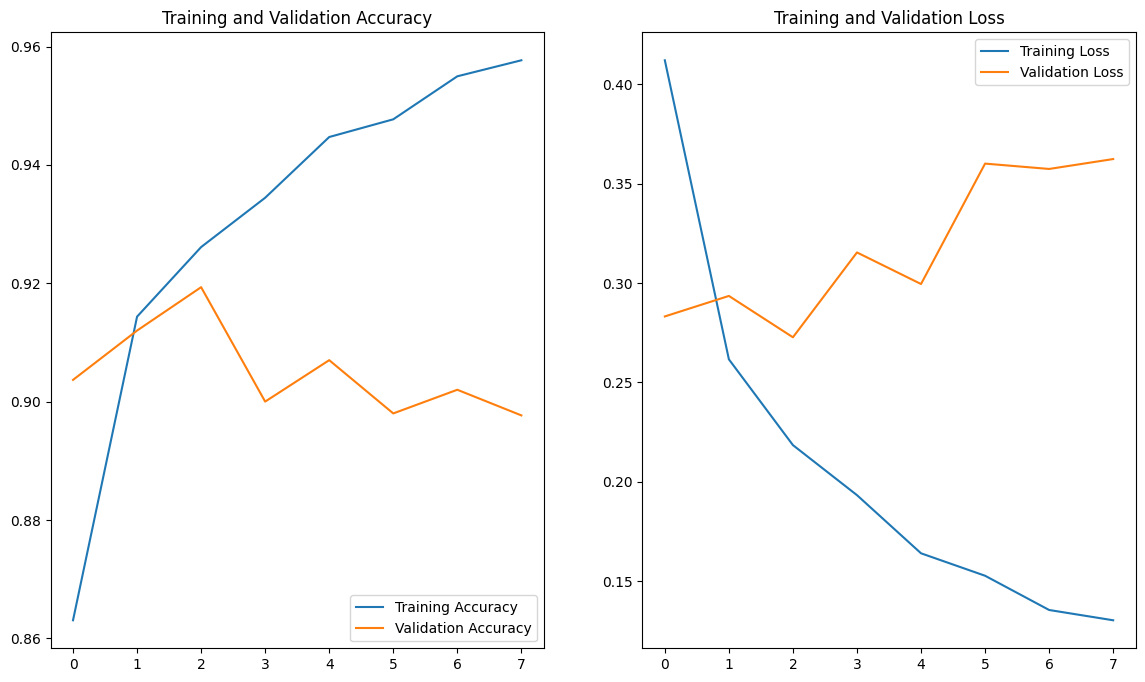

Maximum validation accuracy:  0.9193333387374878
Minimum loss: 0.272707462310791


In [112]:
# Get the accuracy results for each epoch
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
# Get the loss results for each epoch
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Get the epochs count
epochs_range = range(len(history.history["loss"]))

# Create the plot area
plt.figure(figsize=(14, 8))

# Setup the first colum : Accuracy plot
plt.subplot(1, 2, 1)
# Plot the training and validation accuracy for these epochs
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# Setup the legend
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Setup the second colum : Loss plot
plt.subplot(1, 2, 2)
# Plot the training and validation loss for these epochs
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
# Setup the legend
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Show the overall plot
plt.show()

position = np.argmax(history.history["val_accuracy"])
print(f"Maximum validation accuracy:  {history.history['val_accuracy'][position]}\nMinimum loss: {history.history['val_loss'][position]}")

# Examples

In [115]:
data_path_test = "intel-image-classification/seg_pred/seg_pred"

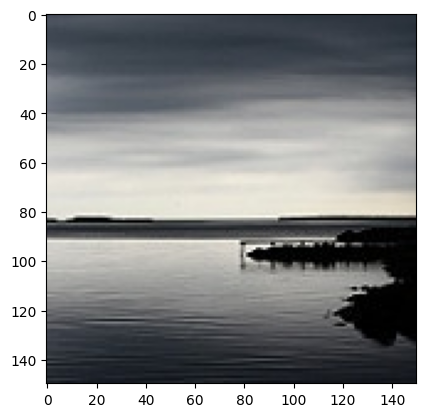

1/1 [==============================] - 3s 3s/step
Predictions CNN: sea
Predictions EfficientNet: sea


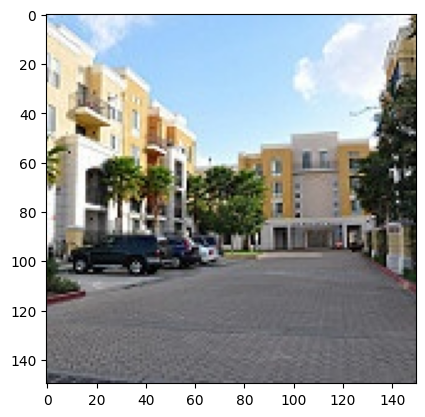

1/1 [==============================] - 0s 33ms/step
Predictions CNN: street
Predictions EfficientNet: street


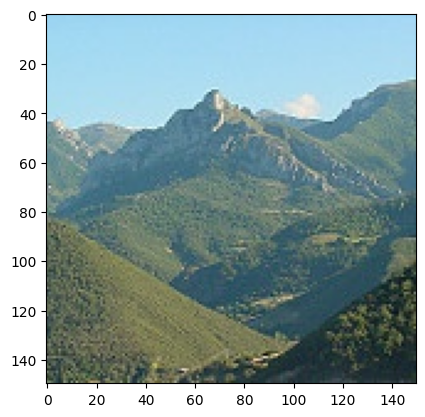

1/1 [==============================] - 0s 29ms/step
Predictions CNN: mountain
Predictions EfficientNet: mountain


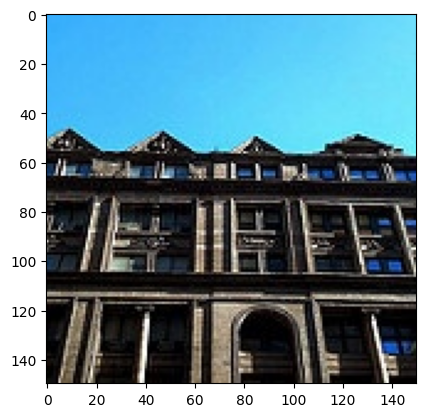

1/1 [==============================] - 0s 29ms/step
Predictions CNN: building
Predictions EfficientNet: building


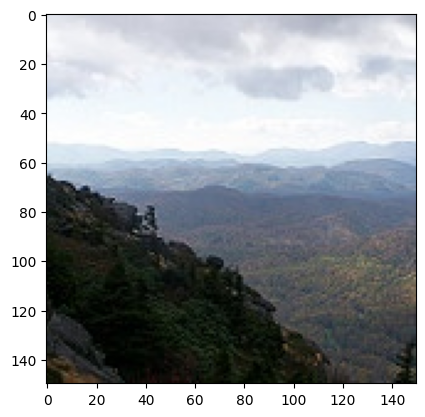

1/1 [==============================] - 0s 31ms/step
Predictions CNN: mountain
Predictions EfficientNet: mountain


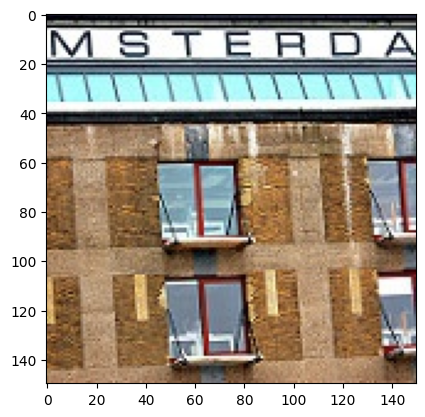

1/1 [==============================] - 0s 29ms/step
Predictions CNN: building
Predictions EfficientNet: building


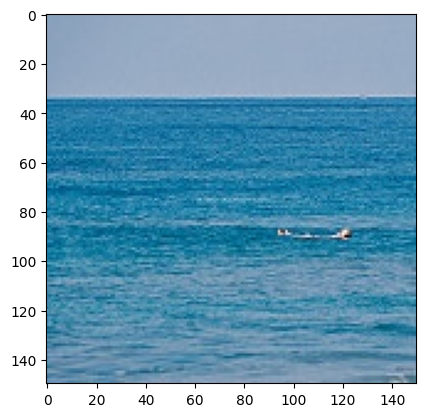

1/1 [==============================] - 0s 30ms/step
Predictions CNN: sea
Predictions EfficientNet: sea


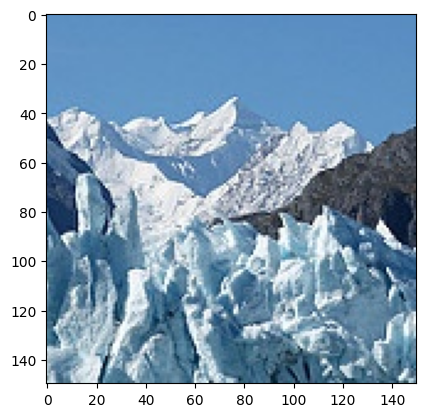

1/1 [==============================] - 0s 31ms/step
Predictions CNN: glaicer
Predictions EfficientNet: glaicer


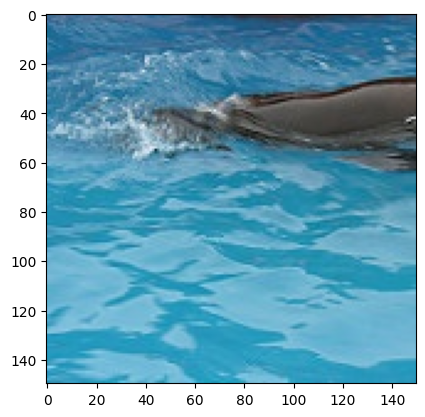

1/1 [==============================] - 0s 28ms/step
Predictions CNN: sea
Predictions EfficientNet: sea


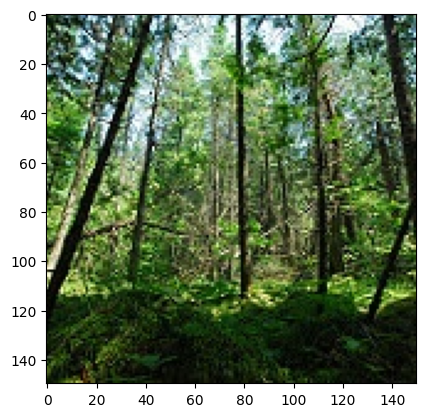

1/1 [==============================] - 0s 29ms/step
Predictions CNN: forest
Predictions EfficientNet: forest


In [116]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


files = os.listdir(data_path_test)

id2label = {
    0: "building",
    1: "forest",
    2: "glaicer",
    3: "mountain",
    4: "sea",
    5: "street"
}

    

# Load the first 10 images
for i in range(10):
    # Construct the full path to the image file
    image_path = os.path.join(data_path_test, files[i])

    # Open the image
    img = Image.open(image_path)
    img = img.resize((width, height))
    
    img=np.array(img)
    plt.imshow(img)
    plt.show()


    img = tf.expand_dims(img, axis=0)
    predictions1 = custom_model.predict(img)
    predictions2 = effnet_model.predict(img)
    most_likely_index1 = np.argmax(predictions1)
    most_likely_index2 = np.argmax(predictions2)
    most_likely_index1 = id2label.get(most_likely_index1, "Unknown")
    most_likely_index2 = id2label.get(most_likely_index2, "Unknown")
    
    # Print or use predictions as needed
    print("Predictions CNN:", most_likely_index1)
    print("Predictions EfficientNet:", most_likely_index1)